# Student Performance Bayesian Network

## Load dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 15)

# load dataset
df = pd.read_csv("datasets/student_prediction.csv")
# print number of missing values
print(df.isna().mean().sum())
df

0.0


,STUDENTID,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,...,PREP_STUDY,PREP_EXAM,NOTES,LISTENS,LIKES_DISCUSS,CLASSROOM,CUML_GPA,EXP_GPA,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,1,2,1,2,1,3,3,9,5
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,1,3,2,2,1,5,3,9,5
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,1,3,3,2,1,4,3,9,1
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,2,1,2,1,2,1,5,3,9,4


In [2]:
# number of unique values per feature, i.e., the state space
df.nunique()

STUDENTID      145
AGE              3
GENDER           2
HS_TYPE          3
SCHOLARSHIP      5
              ... 
CLASSROOM        3
CUML_GPA         5
EXP_GPA          4
COURSE ID        9
GRADE            8
Length: 33, dtype: int64

## Preprocessing

In [3]:
# Preprocessing to combine/aggregate some features
# Replace GRADE by only 2 values, pass (2) or fail (1) 
df['GRADE'] = np.where(df['GRADE'] > 1, 2, 1)
# Combine the parent's education into single feature COMB_EDU by taking the maximum education
df['COMB_EDU'] = np.amax(np.array([df['MOTHER_EDU'], df['FATHER_EDU']]).T, axis=1)

## Build model

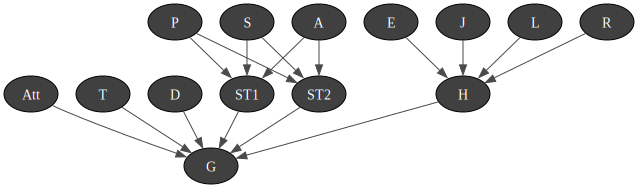

In [24]:
import pyAgrum as gum
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
import pyAgrum.lib.notebook as gnb

bn = gum.BayesNet("Student Performance network")

# Subgraph related to weekly available study hours 
bn.add(gum.LabelizedVariable('R', 'Relationship', ['yes', 'no']))
bn.add(gum.LabelizedVariable('J', 'Additional job', ['yes', 'no']))
bn.add(gum.LabelizedVariable('E', 'Extracurricular activities (sports/arts)', ['yes', 'no']))
bn.add(gum.LabelizedVariable('L', 'Living status', ['rental', 'dormitory', 'with family', 'other']))

bn.add(gum.LabelizedVariable('H','Weekly Study Hours', ['None', '<5 hours', '6-10 hours', '11-20 hours', 'more than 20 hours']))

bn.addArc('R', 'H')
bn.addArc('J', 'H')
bn.addArc('E', 'H')
bn.addArc('L', 'H')

# Subgraph related to nature/nurture
bn.add(gum.LabelizedVariable('A', 'Age', ['18-21', '22-25', 'above 26']))
bn.add(gum.LabelizedVariable('S', 'Sex', ['female', 'male']))
bn.add(gum.LabelizedVariable('P', 'Parents\' education', ['primary school', 'secondary school', 'high school', 'university', 'MSc.', 'Ph.D.']))
bn.add(gum.LabelizedVariable('ST1', 'Study type I', ['alone', 'with friends', 'not applicable']))
bn.add(gum.LabelizedVariable('ST2', 'Study type II', ['last moment', 'regularly', 'never']))

bn.addArcs([(x, y) for x in 'ASP' for y in ['ST1', 'ST2']])

# Combine both subgraphs plus 3 extra nodes
bn.add(gum.LabelizedVariable('T', 'Taking notes', ['never', 'sometimes', 'always']))
bn.add(gum.LabelizedVariable('Att', 'Attendance to class', ['always', 'sometimes', 'never']))
bn.add(gum.LabelizedVariable('D', 'Discussion in class', ['never', 'sometimes', 'always']))

bn.add(gum.LabelizedVariable('G', 'Exam grade', ['fail', 'pass']))

bn.addArc('T', 'G')
bn.addArc('Att', 'G')
bn.addArc('D', 'G')
bn.addArc('ST1', 'G')
bn.addArc('ST2', 'G')
bn.addArc('H', 'G')

gnb.showBN(bn, size=20)
# gnb.showInference(bn)

## Compute conditional probability tables

Prior CPT of:
- $p(A) \qquad p(L)$
- $p(S) \qquad p(R)$
- $p(P) \qquad p(Att)$
- $p(E) \qquad p(T)$
- $p(J) \qquad p(D)$

In [72]:
df.columns

Index(['STUDENTID', 'AGE', 'GENDER', 'HS_TYPE', 'SCHOLARSHIP', 'WORK',
       'ACTIVITY', 'PARTNER', 'SALARY', 'TRANSPORT', 'LIVING', 'MOTHER_EDU',
       'FATHER_EDU', '#_SIBLINGS', 'KIDS', 'MOTHER_JOB', 'FATHER_JOB',
       'STUDY_HRS', 'READ_FREQ', 'READ_FREQ_SCI', 'ATTEND_DEPT', 'IMPACT',
       'ATTEND', 'PREP_STUDY', 'PREP_EXAM', 'NOTES', 'LISTENS',
       'LIKES_DISCUSS', 'CLASSROOM', 'CUML_GPA', 'EXP_GPA', 'COURSE ID',
       'GRADE', 'COMB_EDU'],
      dtype='object')

In [82]:
pd.Series(np.zeros(3, ), [1, 2, 3])

1    0.0
2    0.0
3    0.0
dtype: float64

In [86]:
df['ATTEND'].value_counts(normalize=True)

1    0.758621
2    0.241379
Name: ATTEND, dtype: float64

In [87]:
# nodes related to ST1/ST2 subgraph
age_distr = df['AGE'].value_counts(normalize=True).sort_index()
gender_distr = df['GENDER'].value_counts(normalize=True).sort_index()
parents_edu_distr = df['COMB_EDU'].value_counts(normalize=True).sort_index()

bn.cpt('A').fillWith(age_distr.to_numpy())
bn.cpt('S').fillWith(gender_distr.to_numpy())
bn.cpt('P').fillWith(parents_edu_distr.to_numpy())

# nodes related to H subgraph
act_distr = df['ACTIVITY'].value_counts(normalize=True).sort_index()
job_distr = df['WORK'].value_counts(normalize=True).sort_index()
living_distr = df['LIVING'].value_counts(normalize=True).sort_index()
partner_distr = df['PARTNER'].value_counts(normalize=True).sort_index()

bn.cpt('E').fillWith(act_distr.to_numpy())
bn.cpt('J').fillWith(job_distr.to_numpy())
bn.cpt('L').fillWith(living_distr.to_numpy())
bn.cpt('R').fillWith(partner_distr.to_numpy())

# nodes related to H subgraph
attend_distr = df['ATTEND'].value_counts(normalize=True).sort_index()
zero_vec = pd.Series(np.zeros(3, ), [1, 2, 3])
attend_distr = (zero_vec + attend_distr).fillna(0)

notes_distr = df['NOTES'].value_counts(normalize=True).sort_index()
discuss_distr = df['LIKES_DISCUSS'].value_counts(normalize=True).sort_index()

bn.cpt('Att').fillWith(attend_distr.to_numpy())
bn.cpt('T').fillWith(notes_distr.to_numpy())
bn.cpt('D').fillWith(discuss_distr.to_numpy())

# show all prior probability tables
gnb.sideBySide(*[bn.cpt(x) for x in 'ASPEJLR'], captions=[bn.variable(x).description() for x in 'ASPEJLR'])
irreg_nodes = ['Att', 'T', 'D']
gnb.sideBySide(*[bn.cpt(x) for x in irreg_nodes], captions=[bn.variable(x).description() for x in irreg_nodes])

CPT of $P(ST_1 | A, S, P)$ and $P(ST_2 | A, S, P)$

In [88]:
age_domain = list(range(1, bn.variable('A').domainSize()+1))
gen_domain = list(range(1, bn.variable('S').domainSize()+1))
edu_domain = list(range(1, bn.variable('P').domainSize()+1))

st1_domainsize = bn.variable('ST1').domainSize()
st2_domainsize = bn.variable('ST2').domainSize()
st1_domain = list(range(1, st1_domainsize+1))
st2_domain = list(range(1, st2_domainsize+1))

rv_info = [
    ('ST1', 'PREP_STUDY', st1_domain, st1_domainsize), 
    ('ST2', 'PREP_EXAM',  st2_domain, st2_domainsize)]

for age_i, age in enumerate(age_domain):
    for gen_i, gender in enumerate(gen_domain):
        for edu_i, par_edu in enumerate(edu_domain):
            for (var_name, col_name, dom, dom_size) in rv_info:
                # compute CPT for ST1 and ST2
                conditioned = df[
                    (df['AGE'] == age) &
                    (df['GENDER'] == gender) &
                    (df['COMB_EDU'] == par_edu)][col_name].sort_index()
                
                zero_vec = pd.Series(np.zeros(st1_domainsize, ), st1_domain)
                proba = (zero_vec + conditioned.value_counts(normalize=True)).fillna(0)
                
                if 1 - proba.sum() > 0.001:
                    uniform_distr = np.ones(st1_domainsize, ) / st1_domainsize
                    bn.cpt(var_name)[edu_i, gen_i, age_i, :] = uniform_distr
                else:
                    bn.cpt(var_name)[edu_i, gen_i, age_i, :] = proba.to_numpy()


In [89]:
gnb.sideBySide(bn.cpt('ST1'), bn.cpt('ST2'), captions=['Study type I', 'Study type II'])

CPT of $P(H | E, J, L, R)$

In [90]:
act_domain = list(range(1, bn.variable('E').domainSize()+1))
job_domain = list(range(1, bn.variable('J').domainSize()+1))
liv_domain = list(range(1, bn.variable('L').domainSize()+1))
rel_domain = list(range(1, bn.variable('R').domainSize()+1))

hrs_domainsize = bn.variable('H').domainSize()
hrs_domain = list(range(1, hrs_domainsize+1))

for liv_i, liv in enumerate(liv_domain):
    for act_i, act in enumerate(act_domain):
        for job_i, job in enumerate(job_domain):
            for rel_i, rel in enumerate(rel_domain):
                # compute CPT for H
                conditioned = df[
                    (df['LIVING'] == liv) &
                    (df['ACTIVITY'] == act) &
                    (df['WORK'] == job) & 
                    (df['PARTNER'] == rel)]['STUDY_HRS'].sort_index()
                
                zero_vec = pd.Series(np.zeros(hrs_domainsize, ), hrs_domain)
                proba = (zero_vec + conditioned.value_counts(normalize=True)).fillna(0)
                
                if 1 - proba.sum() > 0.001:
                    uniform_distr = np.ones(hrs_domainsize, ) / hrs_domainsize
                    bn.cpt('H')[liv_i, act_i, job_i, rel_i, :] = uniform_distr
                else:
                    bn.cpt('H')[liv_i, act_i, job_i, rel_i, :] = proba.to_numpy()


In [91]:
bn.cpt('H')

(pyAgrum.Potential<double>@0x2437acd0ab0) 
                           ||  H                                              |
R     |J     |E     |L     ||None     |<5 hours |6-10 hour|11-20 hou|more than|
------|------|------|------||---------|---------|---------|---------|---------|
yes   |yes   |yes   |rental|| 0.0000  | 0.0000  | 0.0000  | 0.0000  | 1.0000  |
no    |yes   |yes   |rental|| 0.1250  | 0.5000  | 0.1250  | 0.2500  | 0.0000  |
yes   |no    |yes   |rental|| 0.0000  | 0.7500  | 0.2500  | 0.0000  | 0.0000  |
no    |no    |yes   |rental|| 0.1250  | 0.6250  | 0.1250  | 0.1250  | 0.0000  |
yes   |yes   |no    |rental|| 0.3333  | 0.3333  | 0.3333  | 0.0000  | 0.0000  |
no    |yes   |no    |rental|| 0.2000  | 0.2000  | 0.6000  | 0.0000  | 0.0000  |
[...20 more line(s) ...]
yes   |no    |yes   |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
no    |no    |yes   |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
yes   |yes   |no    |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
no    |yes   |no    |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |
yes   |no    |no    |other || 0.0000  | 1.0000  | 0.0000  | 0.0000  | 0.0000  |
no    |no    |no    |other || 0.2000  | 0.2000  | 0.2000  | 0.2000  | 0.2000  |

CPT of $p(G | ST_1, ST_2, H, Att, T, D)$

In [93]:
df.columns

Index(['STUDENTID', 'AGE', 'GENDER', 'HS_TYPE', 'SCHOLARSHIP', 'WORK',
       'ACTIVITY', 'PARTNER', 'SALARY', 'TRANSPORT', 'LIVING', 'MOTHER_EDU',
       'FATHER_EDU', '#_SIBLINGS', 'KIDS', 'MOTHER_JOB', 'FATHER_JOB',
       'STUDY_HRS', 'READ_FREQ', 'READ_FREQ_SCI', 'ATTEND_DEPT', 'IMPACT',
       'ATTEND', 'PREP_STUDY', 'PREP_EXAM', 'NOTES', 'LISTENS',
       'LIKES_DISCUSS', 'CLASSROOM', 'CUML_GPA', 'EXP_GPA', 'COURSE ID',
       'GRADE', 'COMB_EDU'],
      dtype='object')

In [95]:
from itertools import product

st1_domain = list(range(1, bn.variable('ST1').domainSize()+1))
st1_domain = list(range(1, bn.variable('ST1').domainSize()+1))
hrs_domain = list(range(1, bn.variable('H').domainSize()+1))
att_domain = list(range(1, bn.variable('Att').domainSize()+1))
tno_domain = list(range(1, bn.variable('T').domainSize()+1))
dis_domain = list(range(1, bn.variable('D').domainSize()+1))

grade_domainsize = bn.variable('G').domainSize()
grade_domain = list(range(1, grade_domainsize+1))

for ((hrs_i, hrs),
     (st2_i, st2),
     (st1_i, st1),
     (dis_i, dis),
     (att_i, att),
     (tno_i, tno)) in product(enumerate(hrs_domain), 
                              enumerate(st2_domain), 
                              enumerate(st1_domain), 
                              enumerate(dis_domain),
                              enumerate(att_domain), 
                              enumerate(tno_domain)):
    # compute CPT for G
    conditioned = df[
        (df['STUDY_HRS'] == hrs) &
        (df['PREP_STUDY'] == st2) &
        (df['PREP_EXAM'] == st1) & 
        (df['LIKES_DISCUSS'] == dis) & 
        (df['ATTEND'] == att) & 
        (df['NOTES'] == tno)]['GRADE'].sort_index()
    
    zero_vec = pd.Series(np.zeros(grade_domainsize, ), grade_domain)
    proba = (zero_vec + conditioned.value_counts(normalize=True)).fillna(0)
    
    if 1 - proba.sum() > 0.001:
        uniform_distr = np.ones(grade_domainsize, ) / grade_domainsize
        bn.cpt('G')[hrs_i, st2_i, st1_i, dis_i, att_i, tno_i, :] = uniform_distr
    else:
        bn.cpt('G')[hrs_i, st2_i, st1_i, dis_i, att_i, tno_i, :] = proba.to_numpy()

In [ ]:
bn.cpt('G')

## Inference

Prior distribution

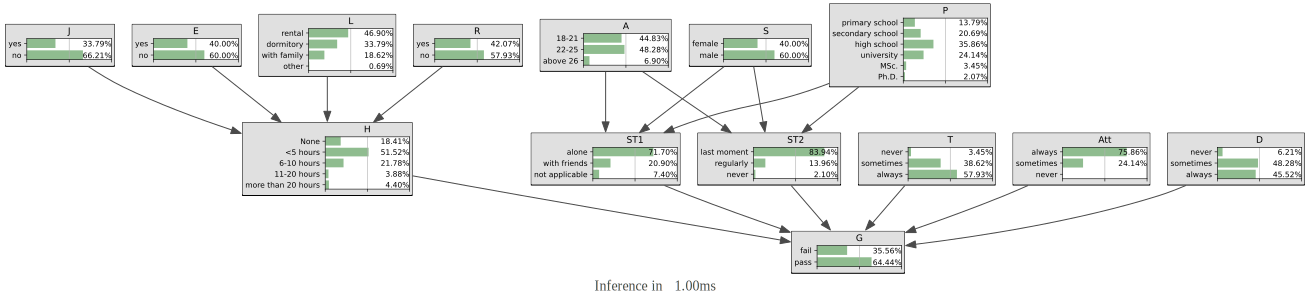

In [98]:
gnb.showInference(bn, evs={}, size='20pt')

$p(G | S=\text{male}, R=\text{yes}, J=\text{yes}, T=\text{never})$

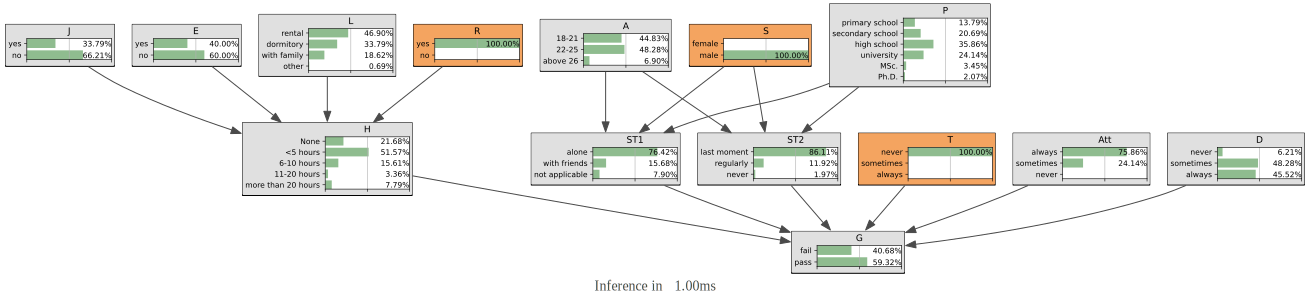

In [101]:
gnb.showInference(bn, evs={'S': 'male', 'R': 'yes', 'T': 'never'}, size='20pt')